## Project 5

## Project 5

In [11]:
from Bio import Phylo
import random
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Rfdist from project 4

In [12]:
def rfdist(T1: object, T2: object) -> int:
    
    """ Part 1: Rooting the trees """

    # Default root is the first sequence in tree 1 that is also found in tree 2.
    # Assumption: at least one sequence is shared between the two trees.
    
    seqNames_T1 = np.array([leaf.name for leaf in T1.get_terminals()])
    seqNames_T2 = np.array([leaf.name for leaf in T2.get_terminals()])

    rootName = None
    for i in seqNames_T1:
        if i in seqNames_T2:
            rootName = i
            break
    
    # Root trees with selected root:
    T1.root_with_outgroup(rootName)
    T2.root_with_outgroup(rootName)

    # Remove root from tree (for convenience):
    T1.prune(rootName)
    T2.prune(rootName)

    """ Part 2: Depth-first numbering """

    # Tree 1:
    numberedLeaves_T1 = {leaf.name: i for i, leaf in enumerate(T1.get_terminals(), start = 1)}

    # Tree 2:
    numberedLeaves_T2 = {} 
    labeller = 1                                                    
    for leaf in T2.get_terminals():
        if leaf.name in numberedLeaves_T1.keys():
            numberedLeaves_T2[leaf.name] = numberedLeaves_T1[leaf.name]
        else:                                                                               
            numberedLeaves_T2[leaf.name] = max(numberedLeaves_T1.values()) + labeller  # In case tree 2 has sequences not present in tree 1, we also label those.
            labeller += 1

    """ Part 3: Identifying individual and shared tree splits """

    def get_splits(tree: object, numberedLeaves: dict, tree1 = False, tree2 = False):
        intervals = []
        potentially_sharedSplits = []

        for clade in tree.find_clades(order = 'postorder'):
            if not clade.is_terminal():
                leaf_numbers = [numberedLeaves[leaf.name] for leaf in clade.get_terminals()]
                min_leaf = min(leaf_numbers)
                max_leaf = max(leaf_numbers)
                intervals.append((min_leaf, max_leaf))

                if tree2 and max_leaf - min_leaf == len(leaf_numbers) - 1: # Checks if leaf numbers in a clade are consecutive. If so, we consider this a potentially shared split.
                    potentially_sharedSplits.append((min_leaf, max_leaf))

        if tree1:
            return intervals
        elif tree2:
            return intervals, potentially_sharedSplits
        else:
            return None

    T1_splits = get_splits(T1, numberedLeaves = numberedLeaves_T1, tree1 = True)
    T2_splits, potentially_sharedSplits = get_splits(T2, numberedLeaves = numberedLeaves_T2, tree2 = True)

    # print(f'\033[1mTree 1 splits:\033[0m {T1_splits}')
    # print(f'\033[1mTree 2 splits:\033[0m {T2_splits}')
    # print(f'\033[1mPotentially shared splits:\033[0m {potentially_sharedSplits}')

    """ Part 4: Calculating the RF distance """
    sharedSplits = set(T1_splits).intersection(potentially_sharedSplits) # Get overlaping splits

    # print(f'\033[1mActually shared splits:\033[0m {sharedSplits}')

    RF_distance = len(T1_splits) + len(T2_splits) - 2 * len(sharedSplits)

    return RF_distance

### Implementation of Neighbour joining


In [13]:
import numpy as np
from io import StringIO
from Bio import Phylo

"""
We need to calculate the Q matrix at every iteration of the NJ algorithm
We need to have Ri and Rj calculated in order to obtain the Q matrix
Ri and Rj: the sum of all the distances of the remaining "labels"/"sequences" leading into Ri/Rj
    Qij = (n - 2) * Dij - Ri - Rj
The non-identical pair with the lowest net divergence are joined to form a new node u
Then we need to calculate the distances from u to the rest of the nodes

Steps:
1. Having D, calculate Q matrix
2. Pick the pair with lowest score
3. Calculate distances from original nodes to newly created node
    d(f, u) = 1/2 (Dfg) + 1/(2 * (n - 2)) * [Rf - Rg]
    d(g, u) = d(f, g) - d(f, u)
4. Calculate new distance matrix using
    Duk = 1/2 [Dfk + Dgk - Dfg]
5. Repeat steps 1-4 until we have three remaining nodes in D
"""

def initiate_dist_matrix(file):
    raw = open(file, "r").read()
    lines_sep = raw.split('\n')

    dim = int(lines_sep[0])
    dist_matrix = np.zeros((dim, dim))

    lines_sep = lines_sep[1:]
    
    labels = []

    for index, line in enumerate(lines_sep):
        if line != "":
            parsed_line = line.split()
            label = parsed_line[0]
            labels.append(label)
            dist_matrix[index, :] = parsed_line[1:]

    return dist_matrix, labels


def calculate_Q(dist_matrix):
    dim = dist_matrix.shape[0]
    Q = np.zeros((dim, dim))

    for i in range(dim):
        for j in range(dim):
            if i == j:
                Q[i][j] = 0
            else:
                r_i, r_j = 0, 0
                for k in range(dim):
                    r_i += dist_matrix[i][k]
                    r_j += dist_matrix[j][k]
                Q[i][j] = (dim - 2) * dist_matrix[i][j] - r_i - r_j
    
    return Q


def find_lowest_pair(Q_matrix):
    dim = Q_matrix.shape[0]
    min_value = float('inf')

    for i in range(dim):
        for j in range(dim):
            if Q_matrix[i][j] < min_value:
                min_value = Q_matrix[i][j]
                min_index = (i, j)
    
    return min_index


def calc_dist_from_orig_to_joined_node(index, dist_matrix):
    # We use these distances as branch length for the tree that we're building

    dim = dist_matrix.shape[0]
    i, j = index
    r_i, r_j = 0, 0
    for k in range(dim):
        r_i += dist_matrix[i][k]
        r_j += dist_matrix[j][k]

    # Calculating distances from the two joined leaves to the new inner node
    d_ki = round((1/2) * dist_matrix[i][j] + (1/(2 * (dim - 2))) * (r_i - r_j), 5)
    d_kj = dist_matrix[i][j] - d_ki

    return d_ki, d_kj


def update_dist_matrix(index, dist_matrix):
    dim = dist_matrix.shape[0]
    new_dist_matrix = np.zeros((dim - 1, dim - 1)) # -1 because we are deleting 2 rows and columns and adding 1

    # Deleting the rows and columns corresponding to the nodes that we are joining together
    f, g = index
    to_delete = [f, g]

    mask = np.ones(dist_matrix.shape[0], dtype = bool)
    mask[to_delete] = False
    temp_matrix = dist_matrix[mask, :][:, mask]

    """
    Copying remaining values from the original distance matrix to the updated one,
    Calculating distances from new node to rest of the nodes
    """
    dim_temp = temp_matrix.shape[0]

    for n in range(dim_temp):
        for m in range(dim_temp):
            new_dist_matrix[n][m] = temp_matrix[n][m]
    
    index_in_new_dist_matrix = 0

    for k in range(dim):
        if k == f or k == g:
            continue
        else:
            new_dist_matrix[dim - 2][index_in_new_dist_matrix] = (1/2) * (dist_matrix[f][k] + dist_matrix[k][g] - dist_matrix[f][g])
            new_dist_matrix[index_in_new_dist_matrix][dim - 2] = (1/2) * (dist_matrix[f][k] + dist_matrix[k][g] - dist_matrix[f][g])
            index_in_new_dist_matrix += 1

    return new_dist_matrix


def calculate_remaining_distances(dist_matrix):
    i, j, m = 0, 1, 2

    # m is the last inner node inserted before the termination
    d_vi = round((1/2) * (dist_matrix[i][j] + dist_matrix[i][m] - dist_matrix[j][m]), 5)
    d_vj = round((1/2) * (dist_matrix[i][j] + dist_matrix[j][m] - dist_matrix[i][m]), 5)
    d_vm = round((1/2) * (dist_matrix[i][m] + dist_matrix[j][m] - dist_matrix[i][j]), 5)

    return d_vi, d_vj, d_vm


def newickify(node_to_children, root_node):
    visited_nodes = set()

    def newick_render_node(name, distance):
        assert name not in visited_nodes, "Error: The tree may not be circular!"

        if name not in node_to_children:
            # Leafs
            return F'{name}:{distance}'
        else:
            # Nodes
            visited_nodes.add(name)
            children = node_to_children[name]
            children_strings = [newick_render_node(child, children[child]) for child in children.keys()]
            children_strings = ",".join(children_strings)
            return F'({children_strings}){name}:{distance}'

    newick_string = newick_render_node(root_node, 0) + ';'

    # Ensure no entries in the dictionary are left unused.
    assert visited_nodes == set(node_to_children.keys()), "Error: some nodes aren't in the tree"

    return newick_string


def neighbor_joining(path_to_dist_matrix):
    """
    Create the input in Newick format somehow, then just make Phylo eat that and draw the tree
    With each addition of a joined node, append an item to the 'labels' list
    """
    D, labels = initiate_dist_matrix(path_to_dist_matrix)
    newick_dict = {}
    inner_node_counter = 1

    while D.shape[0] > 3:
        dict_nested = {}

        Q = calculate_Q(D)
        min_index = find_lowest_pair(Q)
        dist_to_joined = calc_dist_from_orig_to_joined_node(min_index, D)

        # Creating nested dictionary to the two joined leaves and their distance from the new inner node
        dict_nested[labels[min_index[0]]] = dist_to_joined[0]
        dict_nested[labels[min_index[1]]] = dist_to_joined[1]

        inner_node = f"J{inner_node_counter}"
        newick_dict[inner_node] = dict_nested

        # Updating the labels list by adding the new inner node and getting rid of the two joined leaves
        labels.append(inner_node)
        labels = [labels[i] for i in range(len(labels)) if i not in min_index]

        new_dist_matrix = update_dist_matrix(min_index, D)
        D = new_dist_matrix
        inner_node_counter += 1

    # Termination
    d_vi, d_vj, d_vm = calculate_remaining_distances(D)

    inner_node = f"J{inner_node_counter}"

    dict_nested = {}
    dict_nested[labels[0]] = d_vi
    dict_nested[labels[1]] = d_vj
    dict_nested[labels[2]] = d_vm

    newick_dict[inner_node] = dict_nested
    #print(newick_dict)
    # print("Newick dict:", newick_dict)
    # print("Inner node:", inner_node)
    newick_output = newickify(newick_dict, inner_node)
    print(newick_output)

    return newick_output


treedata = neighbor_joining("./example_slide4.phy")
# treedata = neighbor_joining("./unique_distance_matrices/89_Adeno_E3_CR1.phy")
# treedata = neighbor_joining("./unique_distance_matrices/304_A1_Propeptide.phy")
handle = StringIO(treedata)
tree = Phylo.read(handle, "newick")

(C:0.05,E:0.06,(A:0.08,(B:0.1,D:0.07)J1:0.05)J2:0.03)J3:0;


In [7]:
Phylo.draw_ascii(tree)

  ___________________ C
 |
_|________________________ E
 |
 |            ________________________________ A
 |___________|
             |                     _________________________________________ B
             |____________________|
                                  |____________________________ D



#### Experimentation
Allright, so now that the implementation of our own neighbourjoining is complete we can start timing it as it runs on the files within the unique_distance_matrices folder, along with getting the rf-distances for the trees that it leads to.
Ending with a comparison of the rf distances between quicktree and rapidnj.

Since our implementation is very slow, we only ran it on files below a size of 500. Resulting in 5 files.

In [52]:
### WILL TAKE TIME TO RUN THIS CHUNK ### (I stand corrected: It takes a f@#$ing long time)
# Output from this chunk was saved below so dont rerun it.
folder_path = "unique_distance_matrices"
file_list = os.listdir(folder_path)


ourNJ_trees = {}
ourNJ_names = []
exec_times = []

# Since our algorithm takes so long we skip the bigger distance matrices
skip_size = 500
for i, file_name in enumerate(file_list):
    # Skip the larger files
    file_size = file_name.split("_", 1)[0]
    if int(file_size) < skip_size:

        print(i+1, file_name)
        file_path = os.path.join(folder_path, file_name)
        start_time = time.time()
        treedata = neighbor_joining(os.path.join(folder_path, file_name))

        end_time = time.time()
        exec_times.append(end_time - start_time)
        handle = StringIO(treedata)
        tree = Phylo.read(handle, "newick")

        ourNJ_trees[file_name] = tree
        ourNJ_names.append(file_name)
        print("Runtime for {}:".format(file_name), end_time-start_time)

7 214_Arena_glycoprot.phy
{'J1': {'21_Q8AYY5': -0.23393, '22_Q8JZ01': 0.23393}, 'J2': {'10_Q8B120': -0.21827, '11_Q8JZ03': 0.21827}, 'J3': {'26_Q8JZ04': 0.16051, '29_Q8JZ00': 0.17282}, 'J4': {'33_Q84168': -0.18129, '34_Q8JZ05': 0.20832}, 'J5': {'89_Q8JZ02': 0.18724, 'J3': 0.07665000000000002}, 'J6': {'12_Q8B117': -0.10234, 'J2': 0.117865}, 'J7': {'114_Q6PXS': -0.12016, 'J5': 0.08670249999999997}, 'J8': {'32_Q8B116': -0.04207, 'J4': 0.14603}, 'J9': {'16_Q911P0': 0.001, '17_Q8B118': 0.00112}, 'J10': {'31_Q8B121': -0.0169, 'J8': 0.025140000000000003}, 'J11': {'19_A0PJ27': 0.00671, '20_A0PJ25': 0.005920000000000001}, 'J12': {'18_Q8B114': 0.00702, 'J11': 0.0014000000000000002}, 'J13': {'27_Q8AYW1': 0.00367, '28_A1A3Z2': 0.00482}, 'J14': {'6_O11999_': 0.00103, '7_O11997_': 0.0009699999999999999}, 'J15': {'4_VGLY_PI': 0.00463, '5_O11998_': 0.00539}, 'J16': {'14_Q995C5': 0.01139, '15_Q8B119': 0.006609999999999998}, 'J17': {'2_Q9YTW9_': 0.00066, '3_Q9YTW8_': 0.00134}, 'J18': {'J6': 0.12485, '9_

In [94]:
# Save the trees so we dont have to rerun
for i in ourNJ_trees:
    Phylo.write(ourNJ_trees[i], 'output/ourNJ_{}.newick'.format(i), 'newick')

# Save the runtimes
df_our_runtime = pd.DataFrame({'File_name': ourNJ_names, 'runtime': exec_times})
print(df_our_runtime)

df_our_runtime.to_csv('output/ourNJ_runtime.txt', sep='\t', index=False)

                 File_name       runtime
0  214_Arena_glycoprot.phy    547.236813
1    304_A1_Propeptide.phy   2221.412205
2              401_DDE.phy   6747.990623
3     494_Astro_capsid.phy  15677.358084
4      89_Adeno_E3_CR1.phy     17.401156


As seen the scalling as the input size increases is extremely steep 

In [14]:
# Reload the files in
ourNJ_trees = {}
ourNJ_names = []

folder_path = "output"
file_list = os.listdir(folder_path)

for file_name in file_list:
    if file_name.endswith(".newick") and file_name.startswith("ourNJ"):
        file_path = os.path.join(folder_path, file_name)
        tree = Phylo.read(file_path, "newick")
        ourNJ_trees[file_name] = tree
        ourNJ_names.append(file_name)

print(ourNJ_trees)
print(ourNJ_names)

{'ourNJ_214_Arena_glycoprot.phy.newick': Tree(rooted=False, weight=1.0), 'ourNJ_304_A1_Propeptide.phy.newick': Tree(rooted=False, weight=1.0), 'ourNJ_401_DDE.phy.newick': Tree(rooted=False, weight=1.0), 'ourNJ_494_Astro_capsid.phy.newick': Tree(rooted=False, weight=1.0), 'ourNJ_89_Adeno_E3_CR1.phy.newick': Tree(rooted=False, weight=1.0)}
['ourNJ_214_Arena_glycoprot.phy.newick', 'ourNJ_304_A1_Propeptide.phy.newick', 'ourNJ_401_DDE.phy.newick', 'ourNJ_494_Astro_capsid.phy.newick', 'ourNJ_89_Adeno_E3_CR1.phy.newick']


In a seperate bash script, run_quicktree_and_rapidnj.sh, we run the quicktree and rapidnj tools on the 14 files in the folder to get newick formated trees. Additionally we also made an extra tab-seperated textfile to save the run times of each run. 

We load these trees below, we use these later when we compare the rf-distance

In [15]:
folder_path = "output"
file_list = os.listdir(folder_path)

quicktrees = {}
rapidtrees = {}
quick_names = []
rapid_names = []

# files of interest
name_lst = []
for name in ourNJ_names:
    file_size = name.split("_", 2)[1]
    name_lst.append(int(file_size))

for file_name in file_list:
    if file_name.endswith(".newick"): # Is it newick file?
        split_name = file_name.split("_", 2)[1] # Get the file taxa

        if int(split_name) in name_lst: # Check if taxa has been run with our NJ
            if file_name.startswith("quicktree"):
                file_path = os.path.join(folder_path, file_name)
                tree = Phylo.read(file_path, "newick")
                quicktrees[file_name] = tree
                quick_names.append(file_name)

            elif file_name.startswith("rapidnj"):
                file_path = os.path.join(folder_path, file_name)
                tree = Phylo.read(file_path, "newick")
                rapidtrees[file_name] = tree
                rapid_names.append(file_name)

[214, 304, 401, 494, 89]


In [142]:
print(quicktrees)
print(rapidtrees)
print(ourNJ_trees)

{'quicktree_214_Arena_glycoprot.phy.newick': Tree(rooted=False, weight=1.0), 'quicktree_304_A1_Propeptide.phy.newick': Tree(rooted=False, weight=1.0), 'quicktree_401_DDE.phy.newick': Tree(rooted=False, weight=1.0), 'quicktree_494_Astro_capsid.phy.newick': Tree(rooted=False, weight=1.0), 'quicktree_89_Adeno_E3_CR1.phy.newick': Tree(rooted=False, weight=1.0)}
{'rapidnj_214_Arena_glycoprot.phy.newick': Tree(rooted=False, weight=1.0), 'rapidnj_304_A1_Propeptide.phy.newick': Tree(rooted=False, weight=1.0), 'rapidnj_401_DDE.phy.newick': Tree(rooted=False, weight=1.0), 'rapidnj_494_Astro_capsid.phy.newick': Tree(rooted=False, weight=1.0), 'rapidnj_89_Adeno_E3_CR1.phy.newick': Tree(rooted=False, weight=1.0)}
{'ourNJ_214_Arena_glycoprot.phy.newick': Tree(rooted=False, weight=1.0), 'ourNJ_304_A1_Propeptide.phy.newick': Tree(rooted=False, weight=1.0), 'ourNJ_401_DDE.phy.newick': Tree(rooted=False, weight=1.0), 'ourNJ_494_Astro_capsid.phy.newick': Tree(rooted=False, weight=1.0), 'ourNJ_89_Adeno_E3

### Runtimes from the quicktree and rapidnj 

Both the quicktree and rapidnj tool were run through the same bash script on the same PC as the neighbourjoining algorithmen was run.
Below we compare the running time between the 2 methods.

In [60]:
# runtime file
file_path = 'output/runtime.txt'

# loading as dataframe
runtimes = pd.read_csv(file_path, delimiter='\t', header = None)

df = pd.DataFrame(runtimes)
df.columns = ["file_name", "method", "runtime"]

# pivot the data wider
pivot_df = df.pivot(index="file_name", columns="method", values="runtime")

# Add col with differences
pivot_df['difference'] = pivot_df[' quicktree'] - pivot_df[' rapidnj']

print(pivot_df)

method                    quicktree   rapidnj  difference
file_name                                                
1347_FAINT.phy             2.004560  1.043290    0.961270
1493_Fe-ADH.phy            2.441920  1.228590    1.213330
1560_Ferritin.phy          2.956550  1.187280    1.769270
1689_FGGY_N.phy            3.645450  1.195080    2.450370
1756_FAD_binding_3.phy     3.812480  1.263880    2.548600
1849_FG-GAP.phy            4.932030  1.322400    3.609630
214_Arena_glycoprot.phy    0.064064  0.078898   -0.014833
304_A1_Propeptide.phy      0.104915  0.119441   -0.014526
401_DDE.phy                0.139350  0.181053   -0.041703
494_Astro_capsid.phy       0.147846  0.173990   -0.026144
608_Gemini_AL2.phy         0.220852  0.237938   -0.017086
777_Gemini_V1.phy          0.361586  0.308658    0.052928
877_Glu_synthase.phy       0.629708  0.394209    0.235499
89_Adeno_E3_CR1.phy        0.050196  0.054416   -0.004220


We can also plot the runtimes of these two methods to get an idea of how they scale with greater input sizes.

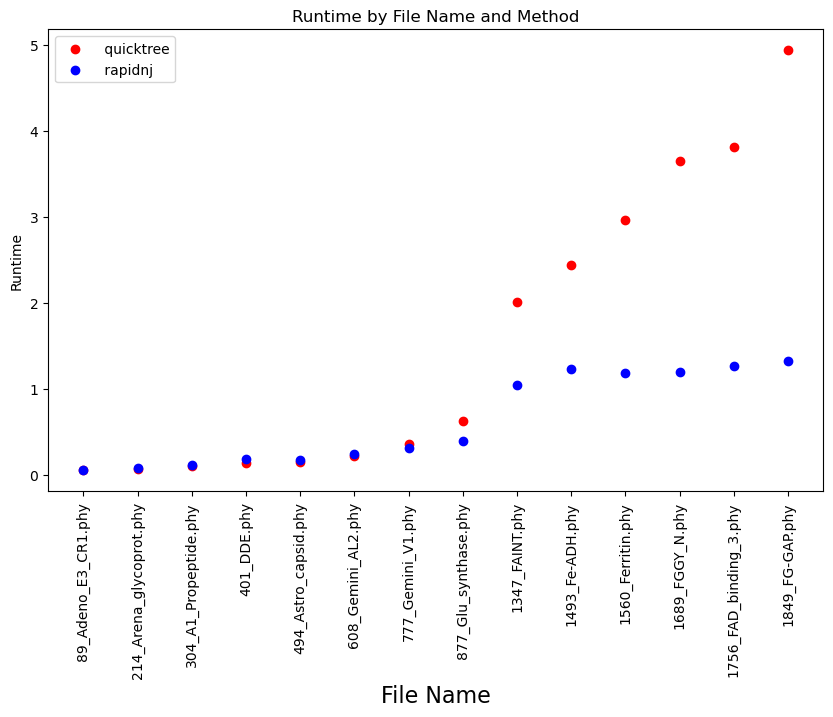

In [61]:
# extract the taxa from file name
numbers = []
for i in range(len(df["file_name"])):
    string = df["file_name"][i]
    number = string.split("_", 1)

    numbers.append(int(number[0]))

df["length"] = numbers

# sort by taxa size
df = df.sort_values(by="length")

# Color the methods
colors = {' quicktree': 'red', ' rapidnj': 'blue'}

# Plot
plt.figure(figsize=(10, 6))

for method, group in df.groupby('method'):
    plt.scatter(group['file_name'], group['runtime'], label=method, color=colors[method])

plt.xlabel('File Name', size = 16)
plt.ylabel('Runtime')
plt.title('Runtime by File Name and Method')
plt.xticks(rotation=90, ha='center')
plt.legend()

plt.show()

For the smaller distance matrices quicktree seems to be slightly faster, but falls off in comparison to rapidnj when the size increases. Meanwhile rapidnj scales slower with greater input sizes. 

### Runtime and rfdist comparison to our implementation
We now compare the runtimes of our own implementation with the 2 tools provided, along with a comparison of the trees generated from them on the same file by comparing the RF-distance.

In [53]:
# our runtime file
file_path_ours = 'output/ourNJ_runtime.txt'
runtimes_ours = pd.read_csv(file_path_ours, delimiter='\t')

# adding headers and method col
runtimes_ours.columns = ['file_name', 'runtime']
runtimes_ours['method'] = 'ourNJ'

name_lst = []
for i in runtimes_ours['file_name']:
    name_lst.append(i)

filtered_df = df[df['file_name'].isin(name_lst)] # Filter out the entries we didnt look at

merged_df = pd.concat([filtered_df, runtimes_ours], ignore_index=True)


# pivot the data wider
pivot_df = merged_df.pivot(index="file_name", columns="method", values="runtime")


# Add col with differences
pivot_df['speed_up_vs_quicktree'] = pivot_df[' quicktree'] / pivot_df['ourNJ']
pivot_df['speed_up_vs_rapidnj'] = pivot_df[' rapidnj'] / pivot_df['ourNJ']



# Calculate the rf_distances between each combination
rfdists_vs_quicktree = []
rfdists_vs_rapidnj = []
rfdists_quick_vs_rapid = []

for i in range(len(ourNJ_names)):
    rfdists_vs_quicktree.append(rfdist(ourNJ_trees[ourNJ_names[i]], quicktrees[quick_names[i]]))
    rfdists_vs_rapidnj.append(rfdist(ourNJ_trees[ourNJ_names[i]], rapidtrees[rapid_names[i]]))
    rfdists_quick_vs_rapid.append(rfdist(quicktrees[quick_names[i]], rapidtrees[rapid_names[i]]))

# Add the rfdist cols
pivot_df["RF_vs_quicktree"] = rfdists_vs_quicktree
pivot_df["RF_vs_rapidnj"] = rfdists_vs_rapidnj
pivot_df["RF_quick_vs_rapid"] = rfdists_quick_vs_rapid

pivot_df

method,quicktree,rapidnj,ourNJ,speed_up_vs_quicktree,speed_up_vs_rapidnj,RF_vs_quicktree,RF_vs_rapidnj,RF_quick_vs_rapid
file_name,,,,,,,,
214_Arena_glycoprot.phy,0.064064,0.078898,547.236813,0.000117,0.000144,28,59,70
304_A1_Propeptide.phy,0.104915,0.119441,2221.412205,0.000047,0.000054,42,101,106
401_DDE.phy,0.139350,0.181053,6747.990623,0.000021,0.000027,70,117,134
494_Astro_capsid.phy,0.147846,0.173990,15677.358084,0.000009,0.000011,194,515,524
89_Adeno_E3_CR1.phy,0.050196,0.054416,17.401156,0.002885,0.003127,32,49,50


As mention before the runtimes are way longer than quicktree and rapidnj, but the difference in rfdistance seems to be smaller for our algorithm than when we compare the trees from quickktree with the trees from rapidnj. 
So our method seems to get the job done.  